In [31]:
import pandas as pd
import numpy as np
import datetime
import time
from tqdm.notebook import tqdm
from datetime import timedelta
import re
import json
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import datetime
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import LinearSegmentedColormap
import pathlib
import matplotlib.ticker as mtick
import gzip

In [37]:
path = 'path/to/data/'
prefix = 'MDPI-2'
start = "2019-12-31"
end = str(datetime.date.today()) #generates todays date
threshold = 1.2

In [32]:
countryGrouping = pd.read_csv(path + 'UNSD — Methodology.csv')
countryGrouping = countryGrouping[['Sub-region Name', 'Country or Area']]
country2region = {}
for index, row in countryGrouping.iterrows():
    country2region[row[1]] = row[0]
country2region['USA'] = 'Northern America'
country2region['Taiwan'] = 'Eastern Asia'
country2region['Hong Kong'] = 'Eastern Asia'
country2region['United Kingdom'] = 'Northern Europe'
country2region['South Korea'] = 'Eastern Asia'
country2region['Vietnam'] = 'South-eastern Asia'
country2region['Iran'] = 'Southern Asia'
country2region['Czech Republic'] = 'Eastern Europe'
country2region['Russia'] = 'Eastern Europe'
country2region['Crimea'] = 'Eastern Europe'
country2region['Brunei'] = 'South-eastern Asia'
country2region['\u200eRomania'] = 'Eastern Europe'
country2region['Venezuela'] = 'Latin America'
country2region['Moldova'] ='Eastern Europe'
country2region['Reunion'] = 'Eastern Africa'
country2region['Curacao'] = 'Latin America'
country2region['Republic of Congo'] = 'Sub-Saharan Africa'
country2region['Palestine'] = 'Western Asia'
country2region['Saint Barthélemy'] = 'Latin America and the Caribbean'
country2region['Saint Martin'] = 'Latin America and the Caribbean'
country2region['CotedIvoire'] = 'Sub-Saharan Africa'
country2region['Czech Repubic'] = 'Eastern Europe'
country2region['St Eustatius'] = 'Latin America and the Caribbean'

countryGrouping = pd.DataFrame.from_dict(country2region, orient="index")
countryGrouping.columns = ["Region"]

omicron = r'B.1.1.529'
BA_1 = r'BA.1|BA.1.*'
BA_2 = r'BA.2|BA.2.*'
BA_3 = r'BA.3|BA.3.*'
BA_4 = r'BA.4|BA.4.*'
BA_5 = r'BA.5|BA.5.*'
delta = r'B.1.617.2|AY.*'
alpha = r'^B\.1\.1\.7$|^Q.*'
beta = r'B.1.351|B.1.351.*'
gamma = r'^P.1|^P.1.*'
mu = r'B.1.621|B.1.621.1'
eta = 'B.1.525'
iota = 'B.1.526'
kappa = 'B.1.617.1'
covlambda = 'C.37'
c12 = 'C.1.2'
epsilon =  r'B.1.427|B.1.429'
zeta = 'P.2'
theta = 'P.3'
xe = 'XE'
xd = 'XD'

def openratiofile(fileprefix):
    ratiodata = pd.read_csv(path + fileprefix + "_ratioData.csv.gz", dtype=object,compression='gzip')  
    ratiodata.columns.values[0] = "sampleID"
    
    with open(path + fileprefix + '_mutlist.txt', 'r') as md:
        mutlist = json.load(md)
    mutations = list(mutlist.keys())

    print('Number of records: ' + str(len(ratiodata)))
    sorteddata = ratiodata.sort_values(["Country","Days"],ascending=[True, True])
    sorteddata["Date"] = pd.to_datetime(sorteddata["Date"])
    date_series = pd.to_datetime(sorteddata["Date"])
    date_index = pd.DatetimeIndex(date_series.values)
    sorteddata.set_index("Date", inplace=True)
    sorteddata = sorteddata.set_index(date_index)
    sorteddata = sorteddata.rename_axis("Date")
    return(sorteddata)
    nameDict={'Lineage':'Strain'}
    sorteddata=sorteddata.rename(columns=nameDict)    
def openR2file(fileprefix,threshold):
    R2_data = pd.read_csv(path + fileprefix + "_countryRatios_" + str(threshold) + ".csv",dtype=object)
    print("data/" + fileprefix + "_countryRatios_" + str(threshold) + ".csv")
    R2_data.columns.values[0] = "Country"
    return(R2_data)

def add_strain(sorteddata):
    sorteddata[mutations] = sorteddata[mutations].apply(pd.to_numeric)
    sorteddata["Strain"] = sorteddata["Strain"].fillna('None')

    sorteddata['WHO'] = ''
    conditions = [
        (sorteddata['Strain'].str.contains(alpha)),
        (sorteddata['Strain'].str.contains(delta)),
        (sorteddata['Strain'].str.contains(beta)),
        (sorteddata['Strain'].str.contains(gamma)),
        (sorteddata['Strain'].str.contains(omicron)),
        (sorteddata['Strain'].str.contains(BA_1)),
        (sorteddata['Strain'].str.contains(BA_2)),
        (sorteddata['Strain'].str.contains(BA_3)),
        (sorteddata['Strain'].str.contains(BA_4)),
        (sorteddata['Strain'].str.contains(BA_5)),
        (sorteddata['Strain'].str.contains(mu)),
        (sorteddata['Strain'].str.contains(eta)),
        (sorteddata['Strain'].str.contains(iota)),
        (sorteddata['Strain'].str.contains(kappa)),
        (sorteddata['Strain'].str.contains(covlambda)),
        (sorteddata['Strain'].str.contains(c12)),
        (sorteddata['Strain'].str.contains(epsilon)),
        (sorteddata['Strain'].str.contains(zeta)),
        (sorteddata['Strain'].str.contains(theta)),
        (sorteddata['Strain'].str.contains(xe)),
        (sorteddata['Strain'].str.contains(xd)),
        (sorteddata['Strain'].str.contains('None'))
    ]
    choices = ['Alpha', 'Delta', 'Beta', 'Gamma', 'Omicron','BA.1','BA.2','BA.3','BA.4','BA.5','Mu','Eta', 'Iota', 'Kappa', 'Lambda', 'c12', 'Epsilon', 'Zeta', 'Theta','XE','XD','None']
    sorteddata['WHO'] = np.select(conditions, choices, default='Other')
    
    cols = sorteddata.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    sorteddata = sorteddata[cols]
    return(sorteddata)

with open(path + prefix +'_mutlist.txt') as f:
    mutlist=json.load(f)
mutations = list(mutlist.keys())

In [33]:
%%time
ratiodata = openratiofile(filestring)
cdata = openR2file(filestring,threshold)
sorteddata = add_strain(ratiodata)

Number of records: 9955794
data/MDPI-2_countryRatios_1.2.csv
CPU times: user 54 s, sys: 21.1 s, total: 1min 15s
Wall time: 1min 25s


In [89]:
#Set manual mutations from list
#mutations = ['D614G+N501Y+P681R_1']
#countriesOfInterest = ['USA','France','Turkey','Brazil','Israel','United Kingdom','Germany','Sweden','Poland','Denmark']

In [129]:
## Calculates 14-day rolling average of all mutations over the period of start-end date
## Calculations are defaulted to countries for GISAID data
heatmapmatrix= {}

for m in tqdm(mutations, desc = 'Calculating mutations rolling average'):
    ref = m    
    subset = cdata[["Country",m]]
    subset.set_index("Country", inplace=True)
    subset.columns = ["Mutation"]
    allcountries = list(cdata["Country"].unique())
    countriesOfInterest = list(subset[subset.Mutation.astype(float) > threshold].index)
    
    #for country in allcountries:
    for country in tqdm(allcountries, desc = 'Calculating for all countries'):
        submut = ratiodata[["Country", m, ref]]
        submut.columns = ["Country","Mutation","Ref"]    
        submut2 = submut.rename(columns = {"Country":"Country",m:"Mutation",ref:"Ref"})
        countlist = ["Mutation", "Ref"]
        submut2[countlist] = submut2[countlist].astype(str).astype(float)
        
        submut2["Mutation"] = np.where(submut2["Mutation"].isin([1]),submut2["Mutation"], 0)
        submut2["Ref"] = np.where(submut2["Ref"].isin([0]),submut2["Ref"], np.nan)
 
        submut2["Ref"] = submut2["Ref"].map({np.nan: 0, 0:1})
        
        countlist = ["Mutation", "Ref"]
        fill = ["Country", submut2.index]
        #sum per day
        idx = pd.date_range(start,end, freq="1D")
        #Count per day mut/ref
        group = submut2.groupby(fill)[countlist].sum()
        group = group.reset_index()
        
        #fill in dates from Day 1 (2020-01-01) to end date
        group2= (group.set_index("Date").groupby("Country").apply(lambda d: d.reindex(pd.date_range(start,end,freq='D')))
            .drop("Country", axis=1).reset_index("Country").fillna(np.nan))
        group2.rename_axis("Date", inplace=True)
        group2[countlist] = group2[countlist].astype(str).astype(float)
        #Rolling sum
        rolled= group2.groupby("Country")[countlist].rolling("14D").sum()
        
        rolled["ratio"] = rolled["Mutation"]/rolled["Ref"] # Calculate mutation ratios
        rolled2 = rolled[["ratio"]]
        rolled3 = rolled2.reset_index("Country")
        
        mutdict = dict.fromkeys(mutations)    
        allratios = {k:v for k, v in rolled3.groupby("Country")["ratio"]}

        mutdict = dict.fromkeys(mutations) 
    
        cdict={}
        #Countries with ratios over threshold
        
        thres_pass = rolled3.loc[rolled3['ratio']>=threshold ]
        cthres = list(thres_pass['Country'].unique())
        allcountriesofinterest = countriesOfInterest + list(set(cthres) - set(countriesOfInterest))
        
        for country in allcountriesofinterest:
            if np.nanmax(rolled3.ratio)>= threshold:
                cdict = dict.fromkeys(allcountriesofinterest)
                keylist = cdict.keys()
                for key in cdict:
                    cdict[key]=allratios[key]
            heatmapmatrix[m]=cdict
        mutdict.update(heatmapmatrix)
        

Calculating mutations rolling average:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating for all countries: 0it [00:00, ?it/s]

## Plot heatmaps with countries above threshold

/var/folders/9m/b69s29212cv909dn6w0wgxg40000gp/T/ipykernel_49709/2219078018.py:40: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


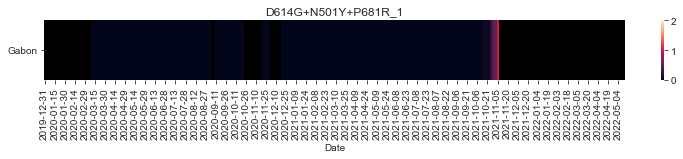

In [131]:
mapp = mutdict
for m in mapp:
    #print(m)
    heatmaptoshow = pd.DataFrame.from_dict(mapp[m])
    heatmaptoshow = heatmaptoshow[start:end]
    results = heatmaptoshow.T
    results.reset_index()
    #results.columns.values[0]='Country'
    results = results.rename_axis("Country")

    result = pd.merge(results, countryGrouping, how="inner", left_index = True, right_index = True)
    result = result.rename_axis("Country")
    #result = result.T
    result = result.sort_values(['Region', 'Country'])
    #result = result.T
    #result.reset_index('Country')
    result = result.drop(['Region'], axis=1)
    result = result.T
    result = result.rename_axis("Date")

    if not result.empty:
        
        plt.figure(figsize = (13,len(result.columns)/10+1))
        #print(heatmaptoshow2.tail(20))
        mask=result.T.isnull()
        show = sns.heatmap(result.T, vmax=2, rasterized=True)
        show.set_facecolor("black")
                   
        ticklabels = [result.index[int(tick)].strftime('%Y-%m-%d') for tick in show.get_xticks()]
        show.set_xticklabels(ticklabels);
        #date_form = DateFormatter("%Y-%m-%d")
        #show.xaxis.set_major_formatter(date_form)
        #show.set_xlim(heatmaptoshow.index.min().date(), heatmaptoshow.index.max().date())
        #show.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
        plt.title(m, size=12)
        plt.yticks(rotation=0)
        show.set(ylabel=None)
        
        show.grid(False)
        plt.tight_layout()
        #fig.figure.savefig('{}{}_{}_{}{}{}'.format(path,m,str(datetime.date.today()),'ratio',threshold,'.pdf'),bbox_inches="tight", dpi=600)
        plt.show(show)
    else:
        print(m)
        print('{}{}{}'.format("No countries with ratio above ", threshold, " for this SNP\n"))




In [228]:
ratiodata[mutations] = ratiodata[mutations].apply(pd.to_numeric)

In [235]:
data = ratiodata
#Save Strain counts for each mutation
mutcounts_m = []
for m in tqdm(mutations, desc = 'Saving mutation counts'):
    if len(data.loc[data[m].astype(int)>0]) != 0:
        #desc = data.reset_index()
        desc = data[['Location', 'Country',m]]
        desc = desc.loc[desc[m]==1]
        desc = desc.groupby(['Country']).describe()
        desc2 = desc[m]['count']
        desc2 = desc2.to_frame()
        desc2.columns.values[0]=m
        mutcounts_m.append(desc2)

mutcounts_m2 = pd.concat(mutcounts_m,axis=1)
mutcounts_m2 = mutcounts_m2.loc[:,~mutcounts_m2.columns.duplicated()]
mutcounts_m2 = mutcounts_m2.replace(np.nan, 0.00)
mutcounts_m2 = pd.DataFrame(mutcounts_m2, columns = [m])
topcountries =mutcounts_m2.sort_values(m, ascending=False).head(10).index.tolist()

Saving mutation counts:   0%|          | 0/1 [00:00<?, ?it/s]

In [236]:
counts = {}
for m in tqdm(mutations):
    subset = ratiodata[["Country",m]]
    subset.set_index("Country", inplace=True)
    subset.columns = ["Mutation"]


    submut = ratiodata[["Country", m]]
    submut.columns = ["Country","Mutation"]    
    submut2 = submut.rename(columns = {"Country":"Country",m:"Mutation"})
    submut2["Mutation"] = submut2["Mutation"].astype(str).astype(int)
    submut2["Mutation"] = np.where(submut2["Mutation"].isin([1]),submut2["Mutation"], 0)

    idx = pd.date_range(start,end, freq="1D")
    fill = ["Country", submut2.index]
    group = submut2.groupby(fill)["Mutation"].sum()
    group = group.reset_index()
    group2= (group.set_index("Date").groupby("Country").apply(lambda d: d.reindex(pd.date_range(start,end,freq='D')))
            .drop("Country", axis=1).reset_index("Country").fillna(np.nan))
    group2["Mutation"] = group2["Mutation"].astype(str).astype(float)
    rolled= group2.groupby("Country")["Mutation"].rolling("14D").sum()
    rolled2 = rolled.reset_index("Country")
    rolled2= rolled2.rename_axis("Date")
    
    countdict = dict.fromkeys(mutations) 
    allcounts = {k:v for k, v in rolled2.groupby("Country")["Mutation"]}
    
    rolled3 = rolled2[['Country','Mutation']]
    #appended_data.append(rolled3)
    rolled3.columns = ["Country",m]  

    for country in topcountries:
        cdict = dict.fromkeys(topcountries)
        keylist = cdict.keys()
        for key in cdict:
            cdict[key]=allcounts[key]
        counts[m]=cdict
    countdict.update(counts)
ylabel = 'Rolling average (14-days)'

  0%|          | 0/1 [00:00<?, ?it/s]

   Country  value
2   Turkey  508.0
0      USA  195.0
1   France  183.0
4   Israel  156.0
3   Brazil   91.0
7   Sweden   55.0
6  Germany   45.0
8   Poland   28.0


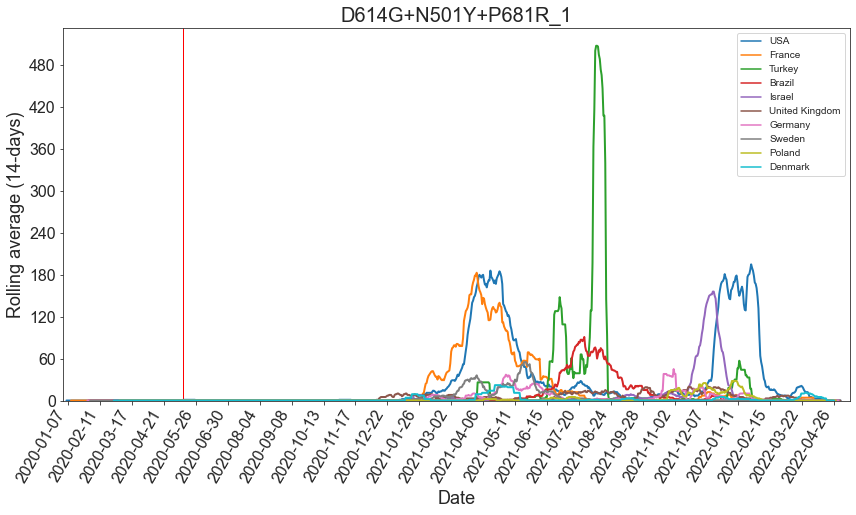

D614G+N501Y+P681R_1


In [239]:
ylabel = 'Rolling average (14-days)'
for m in countdict:
    linegraph = pd.DataFrame.from_dict(countdict[m])
    
    #Get earlist date with mutation
    sub = ratiodata[['Country', m]]
    sub.columns=['Country', "Mutation"]
    minD = sub.loc[sub["Mutation"].astype(float)>0]
    mindate = minD.index.min().date()
    #Max rolling average
    max_value_column = pd.DataFrame(linegraph[1:].max())
    max_value = max_value_column.reset_index()
    max_value.columns =['Country', 'value']
    maxcountry = max_value[max_value.value == max_value.value.max()]
    maxcountries = max_value.sort_values(by=['value'], ascending= False).head(8)
    result = linegraph
    print(maxcountries)

    if not result.empty:
        sns.set_style("ticks")
        
        plt.figure(figsize = (12,7))
        plt.xticks(rotation = 60,horizontalalignment="right")
        plot = sns.lineplot(data =result,
                            dashes=False,
                            palette=sns.color_palette('tab10', n_colors=len(result.columns[:])),linewidth=2)
        plt.title(m,size=20)
        plot.set_ylabel(ylabel, fontsize = 18)
        plot.set_xlabel("Date",fontsize =18)
        plot.tick_params(labelsize=16)
        
        date_form = DateFormatter("%Y-%m-%d")
        plot.xaxis.set_major_formatter(date_form)
        plot.set_xlim(datetime.date(2020, 1, 1), linegraph.index.max().date())
        plot.xaxis.set_major_locator(mdates.WeekdayLocator(interval=5))
        plot.set_ylim(bottom=0)
        
        plot.axvspan(*mdates.datestr2num([str(mindate),str(mindate)]), color = 'red')
        plot.yaxis.set_major_locator(MaxNLocator(integer=True))
        plot.margins(y=0.05)
        
        maxdate = result[maxcountry.iloc[0][0]].idxmax()
        maxdate = maxdate.date()        

        box = plot.get_position()
        plot.set_position([box.x0, box.y0 + box.height * 0.9,
                 box.width, box.height * 0.1])
 
        plt.tight_layout()
        plot.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
        #plot.figure.savefig('{}{}_{}_{}{}'.format(path,m,'_',str(datetime.date.today()),'.pdf'),bbox_inches="tight", dpi=600)

        plt.show(plot)
        print(m)
        
    else:
        print(m)
        print("No observed mutations")